In [104]:
import Path
# We import the libraries we need:
# pandas: to load and clean tables
# numpy: to help with numbers and missing values
# matplotlib and seaborn: to make charts
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Nice default style for charts
sns.set_theme(context="notebook", style="whitegrid")

# Make charts a sensible size
plt.rcParams["figure.figsize"] = (10, 5)

# File locations
RAW_PATH = "../data/raw/google_dirty.csv"
PROCESSED_PATH = "../data/processed/googleads_daily.csv"
IMG_CTR = "../docs/images/ctr_over_time.png"
IMG_SCATTER = "../docs/images/spend_vs_clicks.png"


ModuleNotFoundError: No module named 'Path'

In [71]:
df_raw = pd.read_csv(RAW_PATH, low_memory=False)
print("Shape:", df_raw.shape)
df_raw.head()


Shape: (2600, 13)


,Ad_ID,Campaign_Name,Clicks,Impressions,Cost,Leads,Conversions,Conversion Rate,Sale_Amount,Ad_Date,Location,Device,Keyword
0,A1000,DataAnalyticsCourse,104.0,4498.0,$231.88,14.0,7.0,0.058,$1892,2024-11-16,hyderabad,desktop,learn data analytics
1,A1001,DataAnalyticsCourse,173.0,5107.0,$216.84,10.0,8.0,0.046,$1679,20-11-2024,hyderabad,mobile,data analytics course
2,A1002,Data Anlytics Corse,90.0,4544.0,$203.66,26.0,9.0,NaN,$1624,2024/11/16,hyderabad,Desktop,data analitics online
3,A1003,Data Analytcis Course,142.0,3185.0,$237.66,17.0,6.0,NaN,$1225,2024-11-26,HYDERABAD,tablet,data anaytics training
4,A1004,Data Analytics Corse,156.0,3361.0,$195.9,30.0,8.0,NaN,$1091,2024-11-22,hyderabad,desktop,online data analytic


In [72]:
df = df_raw.copy()

# Make every header lowercase and trim stray spaces
df.columns = [c.strip().lower() for c in df.columns]

# Simple safe renames where needed
# 1) "conversion rate" → "conversion_rate" (header only)
if "conversion rate" in df.columns:
    df = df.rename(columns={"conversion rate": "conversion_rate"})

# 2) If your file uses "campaign_name", rename to "campaign" (header only)
if "campaign_name" in df.columns:
    df = df.rename(columns={"campaign_name": "campaign"})

print("Columns:", list(df.columns))
df.tail()


Columns: ['ad_id', 'campaign', 'clicks', 'impressions', 'cost', 'leads', 'conversions', 'conversion_rate', 'sale_amount', 'ad_date', 'location', 'device', 'keyword']


,ad_id,campaign,clicks,impressions,cost,leads,conversions,conversion_rate,sale_amount,ad_date,location,device,keyword
2595,A3595,DataAnalyticsCourse,88.0,5344.0,$242.07,17.0,9.0,0.054,$1418,29-11-2024,HYDERABAD,MOBILE,online data analytic
2596,A3596,DataAnalyticsCourse,154.0,3211.0,$248.28,14.0,6.0,0.039,$1950,2024/11/28,hyderabad,TABLET,data analitics online
2597,A3597,Data Anlytics Corse,113.0,3808.0,$233.25,18.0,4.0,0.035,$1085,2024-11-02,Hyderbad,desktop,data anaytics training
2598,A3598,Data Analytics Corse,196.0,5853.0,$220.13,16.0,7.0,0.036,$1558,2024-11-08,hydrebad,Tablet,data anaytics training
2599,A3599,Data Analytics Corse,NaN,5453.0,NaN,12.0,5.0,NaN,$1174,2024/11/22,HYDERABAD,desktop,analytics for data


In [73]:
# 1) Pick text columns to clean if they exist
text_cols = [c for c in ["campaign", "network", "device", "location", "keyword"] if c in df.columns]

# 2) Treat common placeholder tokens as missing values (NaN)
placeholders = {"", " ", "-", "n/a", "na", "none", "null", "(not set)", "(not provided)"}

# 3) Base clean: make strings, trim spaces, replace placeholders with NaN
for c in text_cols:
    # df[c] means "the column named c" (a Series inside df)
    df[c] = (df[c].astype(str)
                  .str.strip()
                  .replace({p: np.nan for p in placeholders}))

# 4) Sensible casing:
#    - device, network, keyword → lower case (e.g. "mobile", "search")
#    - location → Title Case (e.g. "Hyderabad")
#    - campaign → collapse multiple spaces to a single space
if "device"   in df: df["device"]   = df["device"].str.lower()
if "network"  in df: df["network"]  = df["network"].str.lower()
if "keyword"  in df: df["keyword"]  = df["keyword"].str.lower()
if "location" in df: df["location"] = df["location"].str.title()
if "campaign" in df: df["campaign"] = df["campaign"].str.replace(r"\s+", " ", regex=True)

# 5) Standardise your campaign variants → one canonical label (the single official spelling)
#    From your data: 'DataAnalyticsCourse', 'Data Anlytics Corse',
#    'Data Analytcis Course', 'Data Analytics Corse' → we choose "Data Analytics Course"
if "campaign" in df.columns:
    canonical = "Data Analytics Course"  # our chosen official name
    # Build a normalised key to match variants (string → strip → lower → collapse spaces)
    camp_key = (df["campaign"].astype(str)
                              .str.strip()
                              .str.lower()
                              .str.replace(r"\s+", " ", regex=True))
    variants = {
        "dataanalyticscourse",
        "data anlytics corse",
        "data analytcis course",
        "data analytics corse",
        "data analytics course",  # include the correct spelling as well
    }
    # Set campaign to the canonical label wherever the normalised value is in our variant set
    df.loc[camp_key.isin(variants), "campaign"] = canonical

# 6) Location standardisation (handles your Hyderabad spellings)
if "location" in df.columns:
    # Already set to Title Case above; create a lowercased matching key
    loc_key = (df["location"].astype(str)
                            .str.strip()
                            .str.lower()
                            .str.replace(r"\s+", " ", regex=True))
    hyderabad_variants = {"hyderabad", "hyderbad", "hydrebad"}
    df.loc[loc_key.isin(hyderabad_variants), "location"] = "Hyderabad"

# 7) Optional: unify a few device/network synonyms using small replacement dicts
if "device" in df.columns:
    device_map = {"smartphone": "mobile", "phone": "mobile", "computer": "desktop", "pc": "desktop"}
    # map + lambda: replace known synonyms, otherwise keep the original
    df["device"] = df["device"].map(lambda x: device_map.get(x, x))

if "network" in df.columns:
    network_map = {"google search": "search", "content": "display", "video": "youtube"}
    df["network"] = df["network"].map(lambda x: network_map.get(x, x))

# 8) Quick preview of cleaned categories (top values)
for c in ["device", "network", "location", "campaign", "keyword"]:
    if c in df:
        print(f"\nTop {c} values:\n", df[c].value_counts(dropna=False).head(10))

# 9) Drop exact duplicate rows (if any)
before = len(df)
df = df.drop_duplicates()
print(f"\nDropped duplicates: {before - len(df)}")



Top device values:
 device
desktop    888
mobile     878
tablet     834
Name: count, dtype: int64

Top location values:
 location
Hyderabad    2600
Name: count, dtype: int64

Top campaign values:
 campaign
Data Analytics Course    2600
Name: count, dtype: int64

Top keyword values:
 keyword
online data analytic      453
learn data analytics      444
data analytics course     440
analytics for data        429
data analitics online     420
data anaytics training    414
Name: count, dtype: int64

Dropped duplicates: 0


In [79]:
def parse_date(s):
    """Try common formats; fall back to UK-friendly inference."""
    for fmt in ("%Y-%m-%d", "%d/%m/%Y", "%d-%m-%Y", "%m/%d/%Y"):
        try:
            return pd.to_datetime(s, format=fmt)
        except Exception:
            pass
    return pd.to_datetime(s, errors="coerce", dayfirst=True)

# Find a likely date column (now that headers are lowercased)
date_candidates = [c for c in df.columns if c in {"ad_date", "day", "report date", "report_date"}]
if not date_candidates:
    raise ValueError("No date column found. Rename your date column to 'date' or add it to date_candidates.")

df = df.rename(columns={date_candidates[0]: "ad_date"})
df["ad_date"] = df["ad_date"].apply(parse_date)

# Remove rows with invalid dates
df = df.dropna(subset=["ad_date"])
df.head()


,ad_id,campaign,clicks,impressions,cost,leads,conversions,conversion_rate,sale_amount,ad_date,location,device,keyword
0,A1000,Data Analytics Course,104.0,4498.0,$231.88,14.0,7.0,0.058,$1892,2024-11-16,Hyderabad,desktop,learn data analytics
1,A1001,Data Analytics Course,173.0,5107.0,$216.84,10.0,8.0,0.046,$1679,2024-11-20,Hyderabad,mobile,data analytics course
2,A1002,Data Analytics Course,90.0,4544.0,$203.66,26.0,9.0,NaN,$1624,2024-11-16,Hyderabad,desktop,data analitics online
3,A1003,Data Analytics Course,142.0,3185.0,$237.66,17.0,6.0,NaN,$1225,2024-11-26,Hyderabad,tablet,data anaytics training
4,A1004,Data Analytics Course,156.0,3361.0,$195.9,30.0,8.0,NaN,$1091,2024-11-22,Hyderabad,desktop,online data analytic


In [80]:
# STEP 6 — Clean numeric fields (cost + sale_amount kept separate)

def to_float_money(x):
    """
    Turn money-like text into a float.
    Examples:
      "£1,234.56" -> 1234.56
      "$2,000"    -> 2000.0
      " 300 "     -> 300.0
    Non-numeric or empty becomes NaN.
    """
    if pd.isna(x):
        return np.nan
    s = str(x).strip()
    for ch in ["£", "$", ",", " "]:
        s = s.replace(ch, "")
    try:
        return float(s)
    except:
        return np.nan

# Coerce core integers
for col in ["impressions", "clicks", "conversions"]:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors="coerce")

# Clean money columns
if "cost" in df.columns:
    df["cost"] = df["cost"].apply(to_float_money)

if "sale_amount" in df.columns:
    df["sale_amount"] = df["sale_amount"].apply(to_float_money)

# Keep essential rows (date + basic activity columns)
need = [c for c in ["ad_date", "impressions", "clicks"] if c in df.columns]
df = df.dropna(subset=need)

# No negatives for these metrics
for c in ["impressions", "clicks", "conversions", "cost", "sale_amount"]:
    if c in df.columns:
        df.loc[df[c] < 0, c] = np.nan

df.head()


,ad_id,campaign,clicks,impressions,cost,leads,conversions,conversion_rate,sale_amount,ad_date,location,device,keyword
0,A1000,Data Analytics Course,104.0,4498.0,231.88,14.0,7.0,0.058,1892.0,2024-11-16,Hyderabad,desktop,learn data analytics
1,A1001,Data Analytics Course,173.0,5107.0,216.84,10.0,8.0,0.046,1679.0,2024-11-20,Hyderabad,mobile,data analytics course
2,A1002,Data Analytics Course,90.0,4544.0,203.66,26.0,9.0,NaN,1624.0,2024-11-16,Hyderabad,desktop,data analitics online
3,A1003,Data Analytics Course,142.0,3185.0,237.66,17.0,6.0,NaN,1225.0,2024-11-26,Hyderabad,tablet,data anaytics training
4,A1004,Data Analytics Course,156.0,3361.0,195.90,30.0,8.0,NaN,1091.0,2024-11-22,Hyderabad,desktop,online data analytic


In [87]:
# KPI definitions (proportions and rates are 0..1 unless you choose to show as % in charts):
# CTR  (Click-Through Rate)     = clicks / impressions
# CPC  (Cost Per Click)         = cost / clicks
# CPM  (Cost Per Mille)         = (cost / impressions) * 1000
# CVR  (Conversion Rate)        = conversions / clicks
# ROAS (Return On Ad Spend)     = sale_amount / cost

# Compute KPIs where inputs exist
if {"clicks", "impressions"}.issubset(df.columns):
    df["ctr"] = np.where(df["impressions"] > 0, df["clicks"] / df["impressions"], np.nan)

if {"cost", "clicks"}.issubset(df.columns):
    df["cpc"] = np.where(df["clicks"] > 0, df["cost"] / df["clicks"], np.nan)

if {"cost", "impressions"}.issubset(df.columns):
    df["cpm"] = np.where(df["impressions"] > 0, df["cost"] / df["impressions"] * 1000, np.nan)

if {"conversions", "clicks"}.issubset(df.columns):
    df["cvr"] = np.where(df["clicks"] > 0, df["conversions"] / df["clicks"], np.nan)

if {"sale_amount", "cost"}.issubset(df.columns):
    df["roas"] = np.where(df["cost"] > 0, df["sale_amount"] / df["cost"], np.nan)

df[["ad_date"] + [c for c in ["impressions","clicks","cost","sale_amount","ctr","cpc","cpm","cvr","roas"] if c in df.columns]].head()


,ad_date,impressions,clicks,cost,sale_amount,ctr,cpc,cpm,cvr,roas
0,2024-11-16,4498.0,104.0,231.88,1892.0,0.023121,2.229615,51.551801,0.067308,8.159393
1,2024-11-20,5107.0,173.0,216.84,1679.0,0.033875,1.253410,42.459369,0.046243,7.743036
2,2024-11-16,4544.0,90.0,203.66,1624.0,0.019806,2.262889,44.819542,0.100000,7.974074
3,2024-11-26,3185.0,142.0,237.66,1225.0,0.044584,1.673662,74.618524,0.042254,5.154422
4,2024-11-22,3361.0,156.0,195.90,1091.0,0.046415,1.255769,58.286224,0.051282,5.569168


In [88]:
# --- STEP 8: Aggregate to daily using 'ad_date' ---

# 1) GROUP KEYS
# Always group by ad_date; then add any optional breakdowns that exist in your DataFrame.
group_keys = ["ad_date"]
for opt in ["campaign", "network", "device", "location"]:
    if opt in df.columns:
        group_keys.append(opt)

# 2) WHAT TO SUM
# Build a dictionary telling pandas how to combine each metric.
# 'sum' makes sense for these (totals for the day).
agg_map = {}
for c in ["impressions", "clicks", "cost", "sale_amount", "conversions"]:
    if c in df.columns:
        agg_map[c] = "sum"

# 3) GROUP + AGGREGATE
# - groupby(group_keys, as_index=False): make groups by the keys, keep them as normal columns.
# - .agg(agg_map): apply the 'sum' operation per group for the listed metrics.
daily = df.groupby(group_keys, as_index=False).agg(agg_map)

# 4) RECOMPUTE KPIs ON TOTALS
# KPIs should be calculated on the aggregated values (not averaged row-by-row),
# because CTR/CPC/CPM/CVR/ROAS are ratios that depend on totals.
if {"clicks", "impressions"}.issubset(daily.columns):
    daily["ctr"] = np.where(daily["impressions"] > 0,
                            daily["clicks"] / daily["impressions"], np.nan)

if {"cost", "clicks"}.issubset(daily.columns):
    daily["cpc"] = np.where(daily["clicks"] > 0,
                            daily["cost"] / daily["clicks"], np.nan)

if {"cost", "impressions"}.issubset(daily.columns):
    daily["cpm"] = np.where(daily["impressions"] > 0,
                            daily["cost"] / daily["impressions"] * 1000, np.nan)

if {"conversions", "clicks"}.issubset(daily.columns):
    daily["cvr"] = np.where(daily["clicks"] > 0,
                            daily["conversions"] / daily["clicks"], np.nan)

if {"sale_amount", "cost"}.issubset(daily.columns):
    daily["roas"] = np.where(daily["cost"] > 0,
                             daily["sale_amount"] / daily["cost"], np.nan)

# 5) OPTIONAL: order the table for readability and do a quick check
daily = daily.sort_values(group_keys)
print("Daily rows:", len(daily))
daily.head()


Daily rows: 123


,ad_date,campaign,device,location,impressions,clicks,cost,sale_amount,conversions,ctr,cpc,cpm,cvr,roas
0,2024-01-11,Data Analytics Course,desktop,Hyderabad,43657.0,1428.0,2127.71,13723.0,58.0,0.032710,1.489993,48.736972,0.040616,6.449657
1,2024-01-11,Data Analytics Course,mobile,Hyderabad,25387.0,858.0,1333.05,8025.0,45.0,0.033797,1.553671,52.509158,0.052448,6.020029
2,2024-01-11,Data Analytics Course,tablet,Hyderabad,24660.0,880.0,1355.63,8483.0,28.0,0.035685,1.540489,54.972830,0.031818,6.257607
3,2024-02-11,Data Analytics Course,desktop,Hyderabad,48900.0,1423.0,2371.15,13874.0,75.0,0.029100,1.666304,48.489775,0.052706,5.851169
4,2024-02-11,Data Analytics Course,mobile,Hyderabad,30505.0,905.0,1562.75,11870.0,53.0,0.029667,1.726796,51.229307,0.058564,7.595585


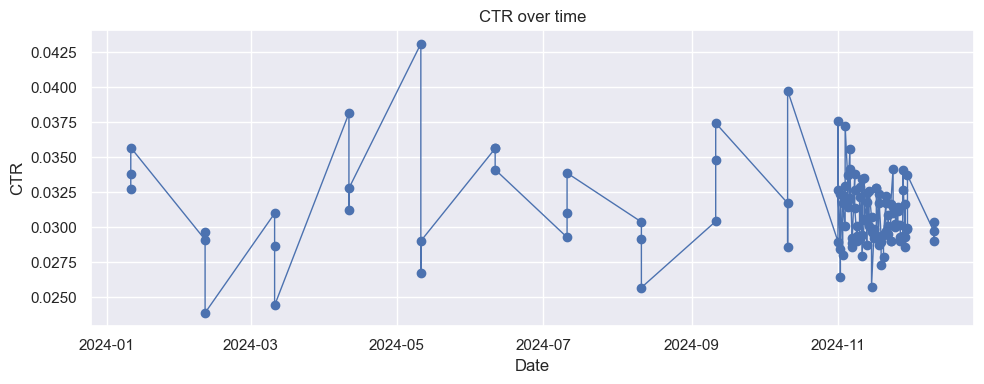

In [91]:
# CTR over time
plt.figure(figsize=(10, 4))
plt.plot(daily["ad_date"], daily["ctr"], marker="o", linewidth=1)
plt.title("CTR over time")
plt.xlabel("Date")
plt.ylabel("CTR")
plt.tight_layout()
plt.savefig(IMG_CTR, dpi=150)
plt.show()


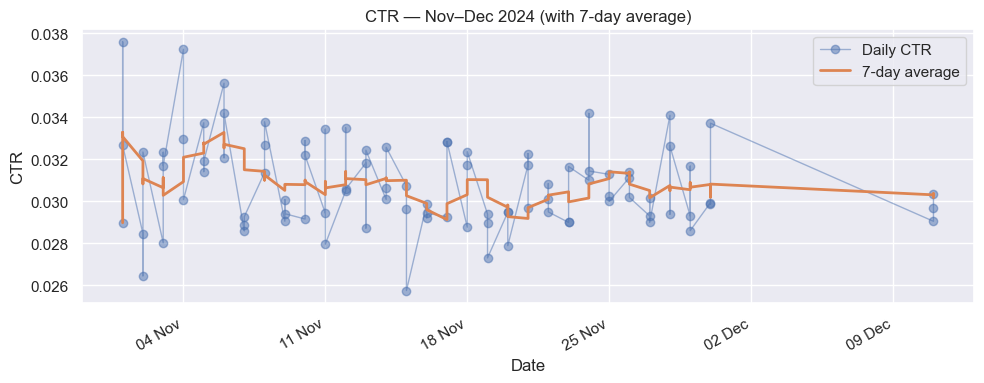

In [105]:
sub["ctr_ma7"] = sub["ctr"].rolling(7, min_periods=1).mean()

fig, ax = plt.subplots(figsize=(10, 4))
ax.plot(sub["ad_date"], sub["ctr"], marker="o", linewidth=1, alpha=0.5, label="Daily CTR")
ax.plot(sub["ad_date"], sub["ctr_ma7"], linewidth=2, label="7-day average")

import matplotlib.dates as mdates
ax.xaxis.set_major_locator(mdates.WeekdayLocator(byweekday=mdates.MO))
ax.xaxis.set_major_formatter(mdates.DateFormatter("%d %b"))
fig.autofmt_xdate()

ax.set_title("CTR — Nov–Dec 2024 (with 7-day average)")
ax.set_xlabel("Date")
ax.set_ylabel("CTR")
ax.legend()
plt.tight_layout()
plt.savefig(IMG_CTR, dpi=150)
plt.show()


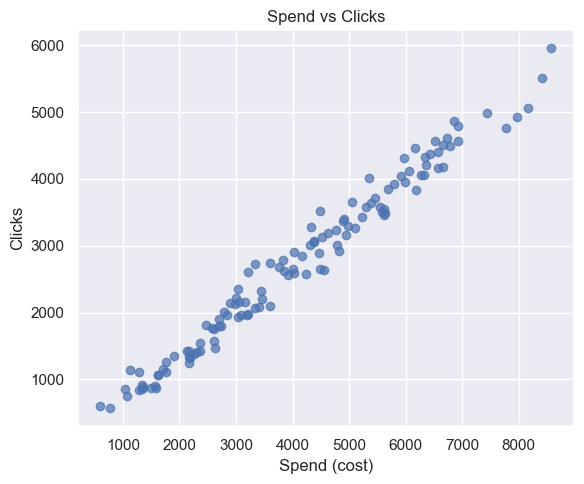

In [92]:
#spned vs clicks

if {"cost", "clicks"}.issubset(daily.columns):
    plt.figure(figsize=(6, 5))
    plt.scatter(daily["cost"], daily["clicks"], alpha=0.7)
    plt.title("Spend vs Clicks")
    plt.xlabel("Spend (cost)")
    plt.ylabel("Clicks")
    plt.tight_layout()
    plt.savefig(IMG_SCATTER, dpi=150)
    plt.show()
else:
    print("Cost or clicks not available to plot.")


In [99]:
Path(PROCESSED_PATH).parent.mkdir(parents=True, exist_ok=True)
daily.to_csv(PROCESSED_PATH, index=False)
print("Saved to:", PROCESSED_PATH)


Saved to: ../data/processed/googleads_daily.csv
